In [ ]:
import numpy as np
import pandas as pd
import torch
import os
import numpy as np
from PIL import Image
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
import os
from PIL import Image
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random
import torch
import torchvision
import numpy as np
import wandb
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import average_precision_score
from torch.utils.data import DataLoader, random_split

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T

class SkinLesionDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")  # Зберігаємо кольори

        mask_np = np.array(mask)
        unique_colors = np.unique(mask_np.reshape(-1, 3), axis=0)

        # Видаляємо фон (наприклад, [0, 0, 255], можна змінити на твій)
        background_colors = [[0, 0, 255], [255, 255, 255], [0, 0, 0]]  # Додай сюди всі можливі фони
        obj_ids = np.array([color for color in unique_colors if not any(np.array_equal(color, bg) for bg in background_colors)])


        masks = np.zeros((len(obj_ids), *mask_np.shape[:2]), dtype=np.uint8)
        for i, color in enumerate(obj_ids):
            masks[i] = np.all(mask_np == color, axis=-1).astype(np.uint8)

        boxes = []
        for i in range(len(obj_ids)):
            pos = np.where(masks[i])
            if pos[0].size == 0 or pos[1].size == 0:
                continue
            ymin, ymax = np.min(pos[0]), np.max(pos[0])
            xmin, xmax = np.min(pos[1]), np.max(pos[1])
            boxes.append([xmin, ymin, xmax, ymax])

        if len(boxes) == 0:
            return T.ToTensor()(img), {
                "boxes": torch.zeros((0, 4), dtype=torch.float32),
                "labels": torch.zeros((0,), dtype=torch.int64),
                "masks": torch.zeros((0, *mask_np.shape[:2]), dtype=torch.uint8),
                "image_id": torch.tensor([idx]),
                "area": torch.zeros((0,), dtype=torch.float32),
                "iscrowd": torch.zeros((0,), dtype=torch.int64)
            }

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([idx]),
            "area": area,
            "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64)
        }

        img = T.ToTensor()(img)

        return img, target


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
dataset = SkinLesionDataset("/kaggle/input/synthetic-merged-moles/images", "/kaggle/input/synthetic-merged-moles/masks")

# Розділення на train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader'и
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [ ]:
len(train_loader)

In [ ]:
len(val_loader)

In [ ]:
def generate_random_color():
    """Функція для генерації випадкового кольору у форматі RGB"""
    return np.random.rand(3,)

def visualize_samples(dataset, num_samples=3):
    if len(dataset) == 0:
        print("❌ Dataset порожній!")
        return

    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 4 * num_samples))

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        img, target = dataset[idx]

        # Перетворення тензора в NumPy (переміщаємо на CPU, якщо потрібно)
        img_np = img.permute(1, 2, 0).cpu().numpy()

        # Візуалізація зображення
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title("Оригінальне зображення")
        axes[i, 0].axis("off")

        # Візуалізація масок для кожної родимки
        masks = target["masks"].cpu().numpy()
        for mask in masks:
            color = generate_random_color()  # Генерація випадкового кольору
            masked_img = np.dstack([mask * color[0], mask * color[1], mask * color[2]])  # Маскуємо зображення кольором
            axes[i, 1].imshow(masked_img, alpha=0.6)  # Виведення маски з кольором

        axes[i, 1].set_title("Маска")
        axes[i, 1].axis("off")

        # Відображення bounding boxes на зображенні
        boxes = target["boxes"].cpu().numpy()
        for box in boxes:
            xmin, ymin, xmax, ymax = box
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='yellow', facecolor='none')
            axes[i, 0].add_patch(rect)  # Додаємо прямокутник на зображення

    plt.tight_layout()
    plt.show()

# Виклик функції для перегляду
visualize_samples(dataset)


In [14]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights="DEFAULT")

num_classes = 2  # 1 клас (родимка) + фон

# Оновлюємо box_predictor
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features_box, num_classes)

# Оновлюємо mask_predictor
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = model.roi_heads.mask_predictor.conv5_mask.out_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# for name, param in model.named_parameters():
#     if "layer4" in name or "roi_heads" in name:
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

for name, param in model.named_parameters():
    if "roi_heads" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


# Визначення оптимізатора для лише тих параметрів, які будуть оновлюватися
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.001, betas=(0.9, 0.999), weight_decay=0.0001)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-14-a2b1ea9669c3>:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [10]:
import numpy as np
import torch
from pycocotools import mask as mask_utils

def mask_to_rle(mask):
    mask = np.array(mask, dtype=np.uint8)
    rle = mask_utils.encode(np.asfortranarray(mask))
    rle_counts = rle["counts"] if isinstance(rle, dict) else rle  # Перевірка, чи є це словником
    if isinstance(rle_counts, bytes):
        rle_counts = rle_counts.decode("utf-8")
    return rle

def prepare_coco_format(targets, predictions):
    """Конвертує GT і передбачення у COCO-формат"""
    gt_annotations = []
    pred_annotations = []
    image_id = 0  
    global_id = 0  

    for target, prediction in zip(targets, predictions):
        # Отримуємо розміри зображення
        height, width = target["masks"].shape[1], target["masks"].shape[2]

        # GT маски
        for i, mask in enumerate(target["masks"]):
            bbox = target["boxes"][i].cpu().numpy()
            x_min, y_min, x_max, y_max = bbox
            coco_bbox = [x_min, y_min, x_max - x_min, y_max - y_min]

            gt_annotations.append({
                "image_id": image_id,
                "category_id": 1,
                "segmentation": mask_to_rle(mask.cpu().numpy()),
                "area": torch.sum(mask).item(),
                "bbox": coco_bbox,
                "iscrowd": 0,
                "id": global_id,
                "height": height,  # Додаємо height
                "width": width     # Додаємо width
            })
            global_id += 1

        # Передбачені маски
        for i, mask in enumerate(prediction["masks"]):
            bbox = prediction["boxes"][i].cpu().numpy()
            x_min, y_min, x_max, y_max = bbox
            coco_bbox = [x_min, y_min, x_max - x_min, y_max - y_min]

            pred_annotations.append({
                "image_id": image_id,
                "category_id": 1,
                "segmentation": mask_to_rle(mask.cpu().numpy()),
                "score": prediction["scores"][i].item(),
                "bbox": coco_bbox,
                "id": global_id,
                "height": height,  # Додаємо height
                "width": width     # Додаємо width
            })
            global_id += 1

        image_id += 1  

    return gt_annotations, pred_annotations


In [11]:
def calculate_iou_matrix(pred_masks, target_masks):
    """Обчислює матрицю IoU між передбаченими та GT масками."""
    iou_matrix = torch.zeros((len(pred_masks), len(target_masks)))

    for i, pred in enumerate(pred_masks):
        for j, gt in enumerate(target_masks):
            intersection = torch.logical_and(pred, gt).sum().float()
            union = torch.logical_or(pred, gt).sum().float()
            iou_matrix[i, j] = intersection / (union + 1e-6)  # Додаємо epsilon для уникнення ділення на 0

    return iou_matrix.numpy()

In [12]:
from scipy.optimize import linear_sum_assignment

def calculate_metrics(model, data_loader):
    model.eval()
    iou_list = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.cuda() for image in images]
            targets = [{k: v.cuda() for k, v in t.items()} for t in targets]

            predictions = model(images)

            for pred, target in zip(predictions, targets):
                pred_masks = (pred['masks'] > 0.5).squeeze(1).cpu()
                target_masks = (target['masks'] > 0.5).cpu()

                if len(pred_masks) == 0 or len(target_masks) == 0:
                    continue

                # IoU для відповідних масок
                iou_matrix = calculate_iou_matrix(pred_masks, target_masks)
                
                if iou_matrix.size > 0 and np.any(iou_matrix > 0):
                    pred_idx, target_idx = linear_sum_assignment(-iou_matrix)
                    matched_ious = iou_matrix[pred_idx, target_idx]
                    iou_list.extend(matched_ious)
    
    mean_iou = np.mean(iou_list) if iou_list else 0.0
    return mean_iou

In [56]:
# from pycocotools.coco import COCO
# from pycocotools.cocoeval import COCOeval
# from scipy.optimize import linear_sum_assignment

# def calculate_metrics(model, data_loader):
#     model.eval()
#     iou_list = []
#     all_gt = []
#     all_preds = []

#     with torch.no_grad():
#         for images, targets in data_loader:
#             images = [image.cuda() for image in images]
#             targets = [{k: v.cuda() for k, v in t.items()} for t in targets]

#             predictions = model(images)

#             for pred, target in zip(predictions, targets):
#                 pred_masks = (pred['masks'] > 0.5).squeeze(1).cpu()
#                 target_masks = (target['masks'] > 0.5).cpu()

#                 if len(pred_masks) == 0 or len(target_masks) == 0:
#                     continue

#                 print('4')

#                 # IoU для відповідних масок
#                 iou_matrix = calculate_iou_matrix(pred_masks, target_masks)
                
#                 if iou_matrix.size > 0 and np.any(iou_matrix > 0):
#                     pred_idx, target_idx = linear_sum_assignment(-iou_matrix)
#                     matched_ious = iou_matrix[pred_idx, target_idx]
#                     iou_list.extend(matched_ious)

#                 # Конвертуємо у COCO-формат
#                 gt_anns, pred_anns = prepare_coco_format([target], [pred])
#                 all_gt.extend(gt_anns)
#                 all_preds.extend(pred_anns)
#                 print(all_gt[0])
#     print('fdfdfefofeofwofowdosdsdc')

#     mean_iou = np.mean(iou_list) if iou_list else 0.0

#     # Обчислення mAP через COCO API
#     coco_gt = COCO()
#     coco_gt.dataset = {
#         "images": [{"id": i} for i in range(len(all_gt))],
#         "annotations": all_gt,
#         "categories": [{"id": 1, "name": "mole"}]
#     }
#     coco_gt.createIndex()

#     if not all_preds:
#         return mean_iou, 0.0

#     coco_dt = coco_gt.loadRes(all_preds)

#     coco_eval = COCOeval(coco_gt, coco_dt, "segm")
#     coco_eval.evaluate()
#     coco_eval.accumulate()
#     coco_eval.summarize()

#     mAP = coco_eval.stats[0]  # AP@[0.5:0.95]

#     return mean_iou, mAP


In [13]:
import wandb
!wandb login 492953ddcda0576b6e6ebf89860aed0ccd177efe

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
from tqdm import tqdm
import wandb
import torch
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt

# Ініціалізація wandb
wandb.init(project="Skin cancer segmentation", name="Mask R-CNN, lr=0.001, 5 epochs new approach")

num_epochs = 5
scaler = torch.cuda.amp.GradScaler()  # Ініціалізація GradScaler
use_amp = torch.cuda.is_available()  # AMP тільки для CUDA

def visualize_prediction(image, mask_gt, mask_pred):
    """Візуалізує GT маску та передбачену маску на оригінальному зображенні."""
    image = image.cpu().permute(1, 2, 0).numpy()
    mask_gt = mask_gt.cpu().numpy()
    mask_pred = mask_pred.cpu().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(mask_gt, cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    axes[2].imshow(mask_pred, cmap="gray")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.tight_layout()
    
    # Логування у WandB
    wandb.log({"segmentation_result": wandb.Image(fig)})
    plt.close(fig)  # Закриваємо, щоб уникнути витоку пам'яті

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") 

    for step, (images, targets) in enumerate(progress_bar):
        images = [image.cuda() for image in images]
        targets = [{k: v.cuda() if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast(enabled=use_amp):  # AMP тільки якщо доступна CUDA
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
        
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += losses.item()
        progress_bar.set_postfix(loss=losses.item())

        # Логування втрат на кожному кроці
        wandb.log({"loss": losses.item(), "step": step + epoch * len(train_loader)})

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Average Loss = {avg_loss:.4f}")

    torch.cuda.empty_cache()

    mean_iou = calculate_metrics(model, val_loader)
    print(f"Epoch {epoch+1}: IoU = {mean_iou:.4f}")
    
    # Логування метрик у wandb
    wandb.log({
        "epoch": epoch + 1,
        "avg_loss": avg_loss,
        "IoU": mean_iou,
    })

    # Логування зображень у wandb
    with torch.no_grad():
        for i, (image, target) in enumerate(val_loader):
            if i >= 2:  # Логувати тільки перші 2 зображення
                break

            image = image[0].cuda()
            target_mask = (target[0]["masks"] > 0.5).cpu()

            prediction = model([image])[0]
            pred_mask = (prediction["masks"] > 0.5).squeeze(1).cpu()

            if len(pred_mask) > 0:  # Якщо є передбачені маски
                visualize_prediction(image, target_mask[0], pred_mask[0])

    # Збереження моделі після епохи
    model_path = f"model_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), model_path)
    wandb.save(model_path)  # Завантажуємо у wandb

# Завершення логування
wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kkaterynabilyk (kkaterynabilyk-lviv-polytechnic-national-university). Use `wandb login --relogin` to force relogin


<ipython-input-15-eeb5e8094520>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Ініціалізація GradScaler
Epoch 1/5:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-15-eeb5e8094520>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):  # AMP тільки якщо доступна CUDA
Epoch 1/5: 100%|██████████| 100/100 [23:31<00:00, 14.12s/it, loss=0.457]


Epoch 1: Average Loss = 0.4714
Epoch 1: IoU = 0.8401


Epoch 2/5: 100%|██████████| 100/100 [23:19<00:00, 14.00s/it, loss=0.36]


Epoch 2: Average Loss = 0.3238


In [19]:
# Тестування моделі
mean_iou, mAP = test_model(model, val_loader)
correct = (pred_masks == target_masks).sum().item()
total = target_masks.numel()
accuracy = correct / total
print(f"Accuracy: {accuracy}")


NameError: name 'test_model' is not defined

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch

model.eval()

# Отримуємо один приклад із валідаційного набору
images, targets = next(iter(val_loader))
image = images[3].cuda().unsqueeze(0)  # Беремо перше зображення з батчу

with torch.no_grad():
    prediction = model(image)[0]

# Перетворюємо зображення у формат для відображення
image_np = F.to_pil_image(images[3].cpu())  # Оригінальне зображення
masks = (prediction["masks"] > 0.5)

# Визначаємо кількість масок
num_masks = len(masks)

# Створюємо область для візуалізації (оригінал + всі маски)
fig, axes = plt.subplots(1, num_masks + 1, figsize=(5 * (num_masks + 1), 5))

# Відображаємо оригінальне зображення
axes[0].imshow(image_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Відображаємо кожну сегментаційну маску
for i in range(num_masks):
    mask = masks[i, 0].cpu().numpy()  # Беремо конкретну маску
    axes[i + 1].imshow(mask, cmap="jet")  # Відображаємо маску
    axes[i + 1].set_title(f"Mask {i+1}")
    axes[i + 1].axis("off")

plt.tight_layout()
plt.show()


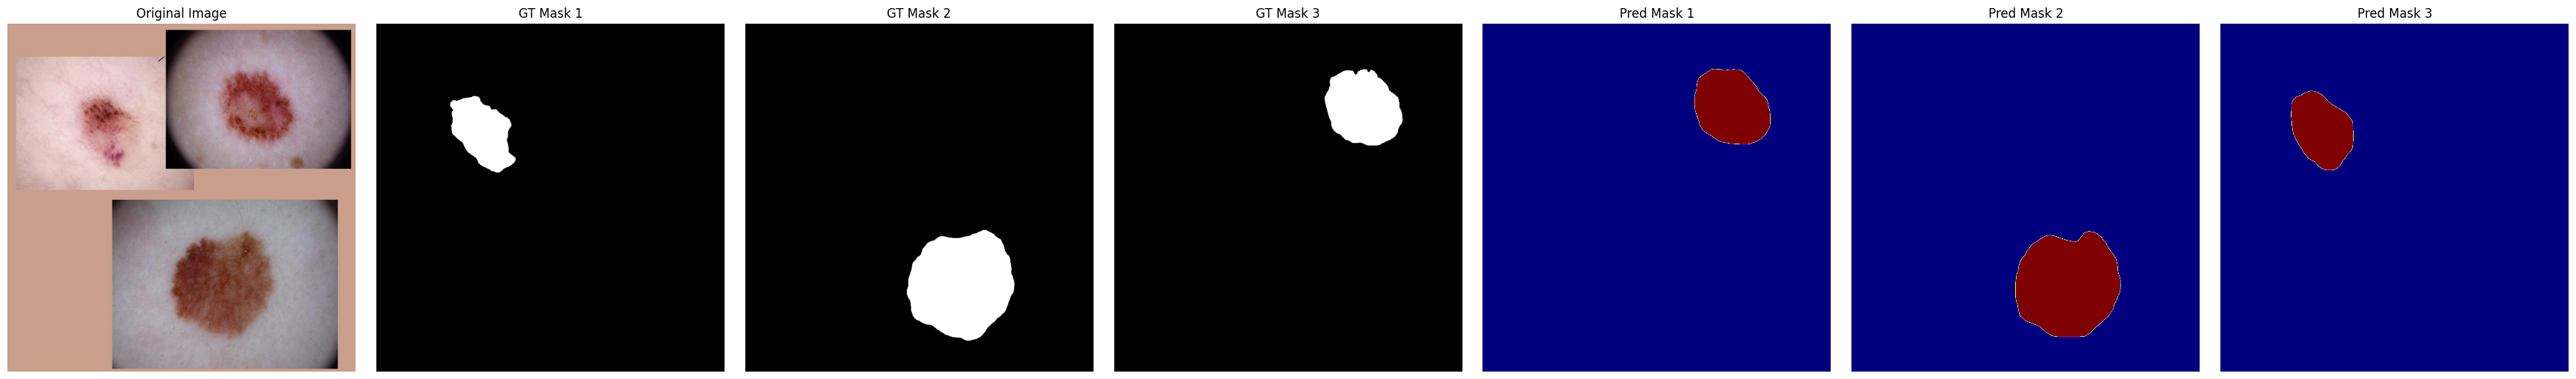

In [17]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch

model.eval()

# Отримуємо один приклад із валідаційного набору
images, targets = next(iter(val_loader))
image = images[5].cuda().unsqueeze(0)  # Беремо зображення

with torch.no_grad():
    prediction = model(image)[0]

# Перетворюємо зображення у формат для відображення
image_np = F.to_pil_image(images[5].cpu())  # Оригінальне зображення
masks = (prediction["masks"] > 0.5).squeeze(1).cpu().numpy()  # Передбачені маски
gt_masks = targets[5]["masks"].cpu().numpy()  # Ground truth маски

# Визначаємо кількість масок
num_pred_masks = len(masks)
num_gt_masks = len(gt_masks)

# Створюємо область для візуалізації (оригінал + ground truth + передбачені маски)
fig, axes = plt.subplots(1, num_pred_masks + num_gt_masks + 1, figsize=(5 * (num_pred_masks + num_gt_masks + 1), 5))

# Відображаємо оригінальне зображення
axes[0].imshow(image_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Відображаємо ground truth маски
for i in range(num_gt_masks):
    axes[i + 1].imshow(gt_masks[i], cmap="gray")
    axes[i + 1].set_title(f"GT Mask {i+1}")
    axes[i + 1].axis("off")

# Відображаємо передбачені сегментаційні маски
for i in range(num_pred_masks):
    axes[num_gt_masks + 1 + i].imshow(masks[i], cmap="jet")
    axes[num_gt_masks + 1 + i].set_title(f"Pred Mask {i+1}")
    axes[num_gt_masks + 1 + i].axis("off")

plt.tight_layout()
plt.show()
